# photometry_blob_22V20.ipynb

2022年DOY309(V20)のblob領域発光の明るさを追跡する。

In [208]:
import numpy as np
import math
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from photutils.aperture import aperture_photometry
from photutils.aperture import CircularAperture
from photutils.aperture import CircularAnnulus
from numba import njit
import os
import pandas as pd

import spiceypy as spice
import hstprojimage as hst
from TScmap import TScmap
import ftpS3

fontname = 'Nimbus Sans'
plt.rcParams.update({'font.sans-serif': fontname,
                    'font.family': 'sans-serif',
                     'mathtext.fontset': 'custom',
                     'mathtext.rm': fontname,
                     'mathtext.it': fontname+':italic',
                     # 'mathtext.bf': 'Nimbus Sans:italic:bold',
                     'mathtext.bf': fontname+':bold'
                     })


cpalette = ['#E7534B', '#EF8C46', '#F7D702', '#3C8867', '#649CDB', '#5341A5', '#A65FAC', '#A2AAAD']

In [197]:
spice.furnsh('kernel/cassMetaK.txt')

# 北半球
filename = 'data/red/2022/309_v20/jup_22-309-23-18-13_0030_v20_stis_f25srf2_flatproj.fits'
# filename = 'data/red/2022/309_v20/jup_22-310-00-00-33_0034_v20_stis_f25srf2_flatproj.fits'

ext = 0
hext = 1
with fits.open(filename) as hdul:
    image = hdul[ext].data # .astype(np.float32)
    h = hdul[hext].header

# HST data
moon = 'EUROPA'
h = hst.HSTProjImage(filename)
h.readHSTFile()
h.MOON = moon
IMG = h.image
hem = h.alm.hemisph
print('hem', hem)

OBS DATE 2022-11-05T23:18:13
hem north


(1000, 1000)


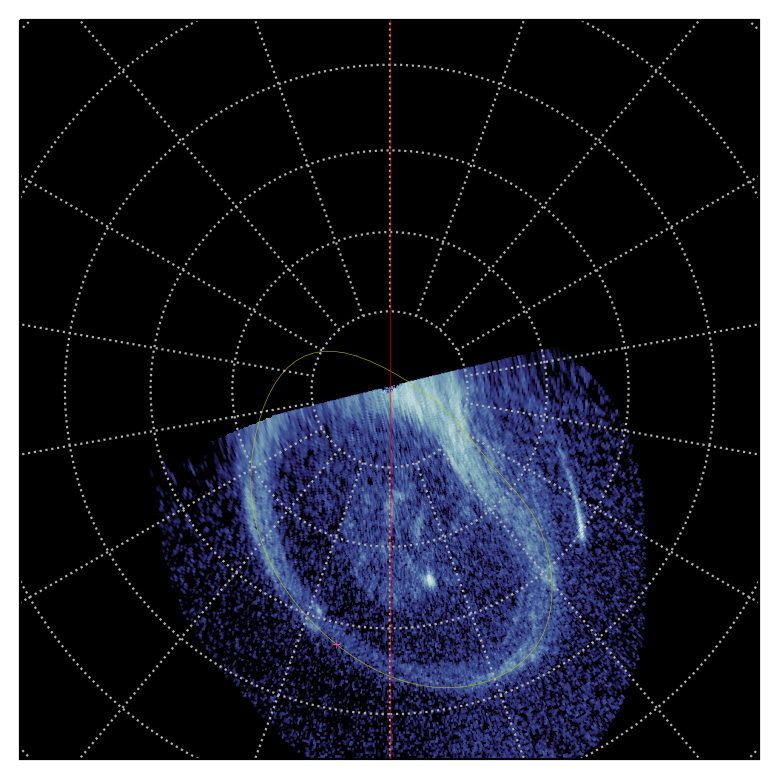

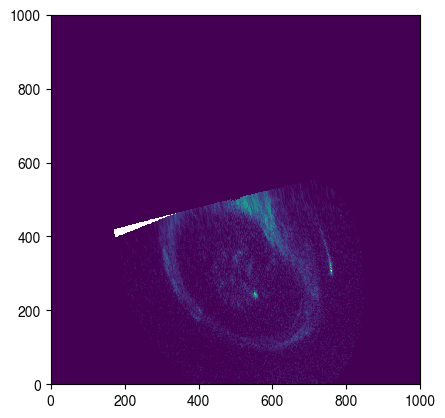

In [198]:
extdeg = 45.0
fig, ax = plt.subplots(dpi=200)
ax, dimage, gl = h.tvPolar(ax, vmin=10, vmax=2000,
                  draw_labels=False, refmainoval=False,
                  satovals=['eu'],
                  reflon=None,
                  # reflon=h.alm.cml,
                  ext=extdeg,
                  zorder=0.5)
ax.axvline(x=0, color='r', linewidth=0.5, alpha=0.5, zorder=100)

print(dimage.shape)
Npx = dimage.shape[0]
dimage = dimage[:,::-1]
if hem == 'south':
    dimage = dimage[:,::-1]
fig, ax = plt.subplots(dpi=100)
ax.set_aspect('equal')
ax.pcolormesh(dimage)
plt.show()

In [199]:
def lat_wlong2px(lat, wlong, N0px, extdeg, hem):
    """_summary_

    Args:
        lat (float): latitude of the point [deg]
        wlong (float): west longitude of the point [deg]
        N0px (int): number of pixels in an axis [px]
        extdeg (float): extent of the image [deg]

    Returns:
        X: X position [px]
        Y: Y position [px]
    """
    if hem=='south':
        lat = lat * (-1)

    elon = 360-(wlong-90)        # [deg]
    colat = 90-lat               # [deg]
    R = (N0px/2)*(np.tan(np.radians(colat/2))/np.tan(np.radians((90-extdeg)/2)))     # [px]
    X = R*np.cos(np.radians(elon))         # [px]
    Y = R*np.sin(np.radians(elon))         # [px]
    X += N0px/2
    Y += N0px/2
    return X, Y

In [200]:
def px2lat_wlong(X, Y, N0px, extdeg, hem):
    """_summary_

    Args:
        X (float): X position(s) [px]
        Y (float): Y position(s) [px]
        N0px (int): number of pixels in an axis [px]
        extdeg (float): extent of the image [deg]

    Returns:
        lat: latitude [deg]
        wlong: west longitude [deg]
    """
    posX = X-N0px/2
    posY = Y-N0px/2

    posR = np.sqrt(posX**2 + posY**2)
    poscolat = np.degrees(2*np.arctan2(posR*np.tan(0.5*np.radians(90-extdeg)), N0px/2))
    postheta = np.arctan2(posY,posX)-0.5*np.pi

    wlong = -np.degrees(postheta)
    lat =  90-poscolat

    if hem=='south':
        lat = lat*(-1)

    return lat, wlong

1st 392.6668689340191 186.5055779231862


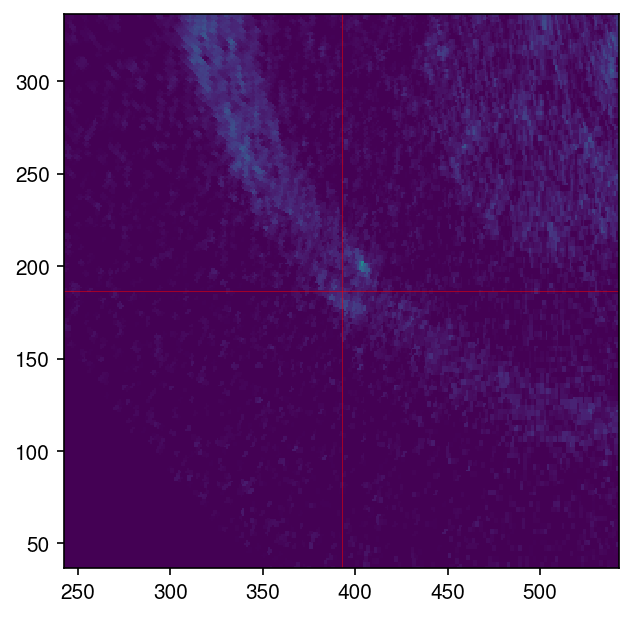

In [201]:
# Blobの中心
ftpX, ftpY = lat_wlong2px(59.3, 198.9, Npx, extdeg, hem)  # footprint best fit
print('1st', ftpX, ftpY)

fig, ax = plt.subplots(dpi=150)
ax.set_aspect('equal')
ax.set_xlim(ftpX-150,ftpX+150)
ax.set_ylim(ftpY-150,ftpY+150)
ax.pcolormesh(dimage, zorder=0.5)
ax.axvline(x=ftpX, color='r', linewidth=0.5, alpha=0.5, zorder=1)
ax.axhline(y=ftpY, color='r', linewidth=0.5, alpha=0.5, zorder=1)
plt.show()

In [202]:
# 22V20における固定値
# t=t0 におけるblob中心
s3lon0 = 197.6      # [deg]
s3nlat0 = 58.7      # [deg]
t0 = '2022-11-05T23:18:13'
t0 = spice.str2et(t0)

# t=t1 におけるblob中心
s3lon1 = 198.9      # [deg]
s3nlat1 = 59.3      # [deg]
t1 = '2022-11-06T00:00:33'
t1 = spice.str2et(t1)

# 線形補間の傾き
dxdt = (s3lon1-s3lon0)/(t1-t0)
dydt = (s3nlat1-s3nlat0)/(t1-t0)

In [203]:
def dataload(filename, extdeg):
    """ Description

    Args:
        filename (str): fits file
        extdeg (float): extent of the image [deg]

    Returns:
        h (class): 
        dimage (np.array): polar projected image
    """

    ext = 0
    hext = 1
    with fits.open(filename) as hdul:
        image = hdul[ext].data      # .astype(np.float32)
        h = hdul[hext].header

    h = hst.HSTProjImage(filename)
    h.readHSTFile()
    h.MOON = 'EUROPA'
    hem = h.alm.hemisph
    print('hem', hem)

    fig, ax = plt.subplots(dpi=200)
    ax, dimage, gl = h.tvPolar(ax, vmin=10, vmax=2000,
                    draw_labels=False, refmainoval=False,
                    satovals=['eu'],
                    reflon=None,
                    # reflon=h.alm.cml,
                    ext=extdeg,
                    )
    plt.close()
    return h, dimage

In [204]:
def Aperture(IMAGE, POSITION):
    """_summary_

    Args:
        IMAGE (2d ndarray): raw image
        POSITION (1d array): position of one spot in the raw image

    Returns:
        apertures (CircularAperture): \n
        rawflux (QTable): QTable including the spot position and the final photometry averaged in pixels. \n
            `['id']` \n
            `['xcenter']` : x position [px] \n
            `['ycenter']` : y position [px] \n
            `['aperture_sum']` : summation of brightness in the target aperture
            `['annulus_median']` : the median inside the donut \n
            `['aper_bkg']` : summation of the median inside the donut \n
            `['final_phot'] = rawflux['aperture_sum'] - rawflux['aper_bkg']` \n
            `['final_phot_ave'] = rawflux['final_phot']/apertures.area`
            
    """
    # Aperture photometry
    apertures = CircularAperture(POSITION, r=5.)
    rawflux = aperture_photometry(IMAGE, apertures)

    # Make a donut to calculate the local background in.
    annulus_apertures = CircularAnnulus(POSITION, r_in=5.5, r_out=9.)

    # Sigma-clipping
    # http://www.astroarts.com/products/stlimg7/support/faq-general/composite_methods-j.shtml
    annulus_masks = annulus_apertures.to_mask(method='center')

    # Mask inside the donut
    annulus_data = annulus_masks.multiply(IMAGE)
    annulus_data_1d = annulus_data[annulus_masks.data > 0]  # 輪っか内部の値だけ抽出

    # Calculate the median as the local background
    _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
    bkg_median = median_sigclip*1.0

    # Add results to the rawflux data
    rawflux['annulus_median'] = bkg_median
    rawflux['aper_bkg'] = bkg_median*apertures.area
    rawflux['final_phot'] = rawflux['aperture_sum'] - rawflux['aper_bkg']
    rawflux['final_phot_ave'] = rawflux['final_phot']/apertures.area
    
    return apertures, rawflux

In [205]:
year = '2022'
yearlydata_dir = 'data/red/'+year
doy_visit_list = sorted(os.listdir(yearlydata_dir))
print(doy_visit_list[8])
doyvisit = doy_visit_list[8]
fits30s = sorted(os.listdir(yearlydata_dir+'/'+doyvisit))

savedir = 'img/blob/EUROPA/'+year+'/'+doyvisit

try:
    os.makedirs(savedir)
except FileExistsError:
    savedir += '_R'
    os.makedirs(savedir)

brightnessCSV = ['date', 'lat [deg]', 'wlong [deg]', 'Moon S3 [deg]', 'spot brightness [kR]', 'local background [kR]']
brightlist = np.zeros((len(fits30s), 5)).tolist()

for j in range(len(fits30s)):
    dataname = yearlydata_dir+'/'+doy_visit_list[8]+'/'+fits30s[j]

    h, dimage = dataload(dataname, extdeg)
    hem = h.alm.hemisph

    Npx = dimage.shape[0]
    dimage = dimage[:,::-1]
    if hem == 'south':
        dimage = dimage[:,::-1]

    et = spice.str2et(h.datetime)

    # 線形補間 - Blobの中心
    xt = dxdt*(et-t0) + s3lon0
    yt = dydt*(et-t0) + s3nlat0
    poslat = yt
    poswlong = xt

    # 緯度経度からピクセルに変換
    ftpX, ftpY = lat_wlong2px(yt, xt, Npx, extdeg, hem)  # footprint best fit
    print('1st', ftpX, ftpY)

    """
    fig, ax = plt.subplots(dpi=150)
    ax.set_aspect('equal')
    ax.set_xlim(ftpX-150,ftpX+150)
    ax.set_ylim(ftpY-150,ftpY+150)
    ax.pcolormesh(dimage, zorder=0.5)
    ax.axvline(x=ftpX, color='r', linewidth=0.5, alpha=0.5, zorder=1)
    ax.axhline(y=ftpY, color='r', linewidth=0.5, alpha=0.5, zorder=1)
    plt.show()
    """
    
    positions = np.array([ftpX, ftpY])
    aper, rawflux = Aperture(dimage, positions)

    brightlist[j] = [h.datetime, poslat, poswlong, h.s3moon, rawflux['final_phot_ave'][0], rawflux['annulus_median'][0]]

df = pd.DataFrame(brightlist)
df.to_csv(savedir+'/brightness.csv', header=brightnessCSV, sep='\t')


309_v20
OBS DATE 2022-11-05T23:18:13
hem north
1st 397.7487642592758 177.66326390349508
OBS DATE 2022-11-05T23:18:23
hem north
1st 397.7280877529216 177.69797835774682
OBS DATE 2022-11-05T23:18:33
hem north
1st 397.7074165387628 177.73269363828967
OBS DATE 2022-11-05T23:18:43
hem north
1st 397.6867506167643 177.76740974449035
OBS DATE 2022-11-05T23:18:53
hem north
1st 397.6660899868903 177.80212667571618
OBS DATE 2022-11-05T23:19:03
hem north
1st 397.6454346491057 177.8368444313333
OBS DATE 2022-11-05T23:19:13
hem north
1st 397.624784603375 177.87156301070894
OBS DATE 2022-11-05T23:19:23
hem north
1st 397.60413984966317 177.90628241320974
OBS DATE 2022-11-05T23:19:33
hem north
1st 397.5835003879338 177.94100263820246
OBS DATE 2022-11-05T23:19:43
hem north
1st 397.56286621815195 177.97572368505405
OBS DATE 2022-11-05T23:19:53
hem north
1st 397.5422373402814 178.0104455531315
OBS DATE 2022-11-05T23:20:03
hem north
1st 397.5216137542866 178.0451682418012
OBS DATE 2022-11-05T23:20:13
hem n

### PLOT

In [209]:
def load(csvname0):
    df = pd.read_csv(csvname0, sep='\t')
    utc = df.loc[:, 'date']                                 # UTC date
    efplat = df.loc[:, 'lat [deg]'].values                  # EFP latitude [deg]
    efpwlong = df.loc[:, 'wlong [deg]'].values              # EFP System III longitude [deg]
    moons3 = df.loc[:, 'Moon S3 [deg]'].values              # Europa's System III longitude [deg]
    final_phot_ave = df.loc[:, 'spot brightness [kR]']      # EFP brightness [kR]
    annulus_median = df.loc[:, 'local background [kR]']     # local background [kR]
    
    b0_arr = np.zeros(len(final_phot_ave))
    b1_arr = np.zeros(len(final_phot_ave))
    efplat0_arr = np.zeros(len(final_phot_ave))
    efpwlong0_arr = np.zeros(len(final_phot_ave))
    moons30_arr = np.zeros(len(final_phot_ave))
    for i in range(len(final_phot_ave)):
        if final_phot_ave[i] != '0':
            b0_arr[i] = final_phot_ave[i]
            b1_arr[i] = annulus_median[i]
            efplat0_arr[i] = efplat[i]
            efpwlong0_arr[i] = efpwlong[i]
            moons30_arr[i] = moons3[i]
        else:
            continue
    
    return utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr

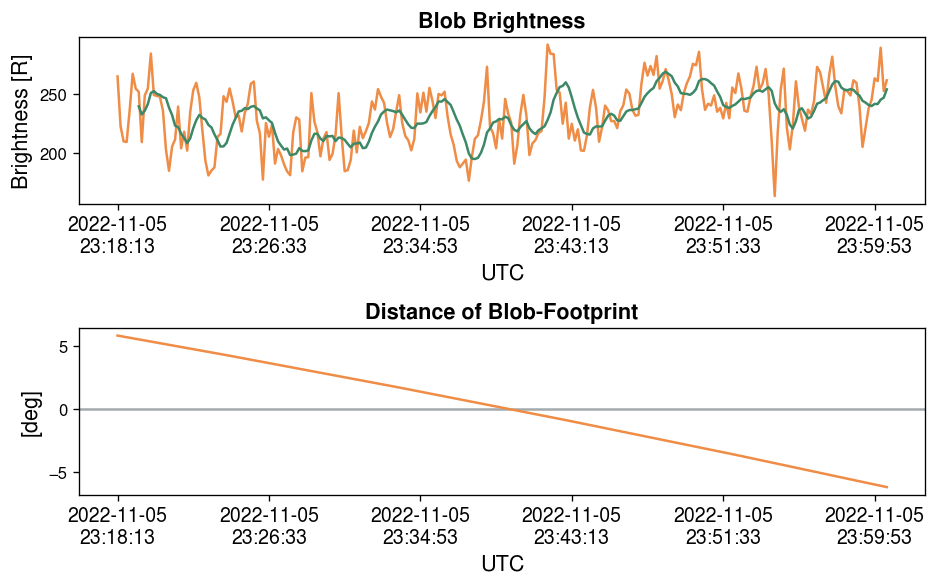

In [220]:
satoval = np.recfromtxt('ref/2021je007055-sup-0003-table si-s02.txt', skip_header=3,
    names=['wlon', 'amlat', 'amwlon', 'iolat', 'iowlon', 'eulat', 'euwlon', 'galat', 'gawlon'])

utc, b0_arr, b1_arr, bloblat0_arr, blobwlong0_arr, moons30_arr = load(savedir+'/brightness.csv')
et_list = np.zeros(utc.shape)
utc_labels = list(np.zeros(utc.shape))
EFPwlon = np.zeros(utc.shape)   # Instantaneous EFP
for i in range(utc.shape[0]):
    et_list[i] = spice.str2et(utc[i])
    utcs = utc[i].split('T')    # 時刻表示'T'を改行'\n'に置換する
    utc_labels[i] = utcs[0]+'\n'+utcs[1]
    _, s3wlon_lin, s3lat_lin, _, _ = ftpS3.ftpS3().FP(utc[i], satoval, 'EUROPA')
    EFPwlon[i] = blobwlong0_arr[i]-s3wlon_lin

# 移動平均
num = 8
conv = np.convolve(b0_arr+b1_arr, np.ones(num), mode='valid')/num
et_list2 = et_list[num-1:]

# Plot
fontsize = 13
fig, ax = plt.subplots(2,1,figsize=(8,5), dpi=120)
ax[0].set_title('Blob Brightness', weight='bold', fontsize=fontsize)
ax[0].set_xlabel('UTC', fontsize=fontsize)
ax[0].set_ylabel('Brightness [R]', fontsize=fontsize)
ax[0].set_xticks(et_list[::50])
ax[0].set_xticklabels(utc_labels[::50], fontsize=fontsize*0.9)
ax[0].plot(et_list, b0_arr+b1_arr, color=cpalette[1])
ax[0].plot(et_list2, conv, color=cpalette[3])

ax[1].set_title('Distance of Blob-Footprint', weight='bold', fontsize=fontsize)
ax[1].set_xlabel('UTC', fontsize=fontsize)
ax[1].set_ylabel('[deg]', fontsize=fontsize)
ax[1].set_xticks(et_list[::50])
ax[1].set_xticklabels(utc_labels[::50], fontsize=fontsize*0.9)
ax[1].plot(et_list, EFPwlon, color=cpalette[1])
ax[1].axhline(y=0, color='#A2AAAD', zorder=0.5)
fig.tight_layout()
plt.show()